# **Technical Analysis**

In [1]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.4 MB/s eta 0:00:00


In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=78c077860d96483c219115304102de41ee97a813c016c40f8dbb98786a96f301
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import ta
import requests
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from google.colab import drive
from datetime import datetime, timedelta


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
tickers_csv_path = "/content/drive/My Drive/StockDashboard_Automation/ExportToGitHub/Top Ten Tickers.csv"
df_tickers = pd.read_csv(tickers_csv_path)
selected_ticker = df_tickers.iloc[0, 0]

print(f"📌 Selected Ticker: {selected_ticker}")

📌 Selected Ticker: NVDA


In [25]:
symbol=selected_ticker


In [26]:
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey=YRVTL6XMGYSBO2JN&outputsize=full"
response = requests.get(url).json()
time_series = response.get("Time Series (Daily)", {})
stock_data = []
for date, values in time_series.items():
    stock_data.append({
        "Date": pd.to_datetime(date),
        "Open": float(values["1. open"]),
        "High": float(values["2. high"]),
        "Low": float(values["3. low"]),
        "Close": float(values["4. close"])
    })


df_stock=  pd.DataFrame(stock_data)


symbol=selected_ticker



In [27]:
df_stock = df_stock.iloc[::-1]
df_stock.reset_index(drop= True)

,Date,Open,High,Low,Close
0,1999-11-01,21.75,24.3800,21.75,23.50
1,1999-11-02,23.94,25.1300,23.75,25.00
2,1999-11-03,26.00,28.1300,25.81,27.44
3,1999-11-04,27.75,29.9400,27.75,29.19
4,1999-11-05,30.00,30.2500,26.88,28.25
...,...,...,...,...,...
6410,2025-04-28,109.69,110.3699,106.02,108.73
6411,2025-04-29,107.67,110.1999,107.44,109.02
6412,2025-04-30,104.47,108.9200,104.08,108.92
6413,2025-05-01,113.08,114.9400,111.30,111.61


# **Trading View Mechanism for Technical Score **

In [28]:
# Calculate Technical Indicators
df_stock["SMA_50"] = ta.trend.sma_indicator(df_stock["Close"], window=50)
df_stock["SMA_200"] = ta.trend.sma_indicator(df_stock["Close"], window=100)
df_stock["RSI"] = ta.momentum.rsi(df_stock["Close"], window=14)
df_stock["MACD_Line"] = ta.trend.MACD(df_stock["Close"]).macd()
df_stock["MACD_Signal"] = ta.trend.MACD(df_stock["Close"]).macd_signal()
df_stock["Bollinger_Upper"] = ta.volatility.bollinger_hband(df_stock["Close"])
df_stock["Bollinger_Lower"] = ta.volatility.bollinger_lband(df_stock["Close"])
df_stock["ATR"] = ta.volatility.average_true_range(df_stock["High"], df_stock["Low"], df_stock["Close"])
df_stock["Momentum"] = ta.momentum.roc(df_stock["Close"], window=10)



# Normalize Indicator Scores (0-100 Scale)
def normalize(value, min_val, max_val):
    return ((value - min_val) / (max_val - min_val)) * 100

df_stock["RSI_Score"] = normalize(df_stock["RSI"], 0, 100)
df_stock["MACD_Score"] = normalize(df_stock["MACD_Line"] - df_stock["MACD_Signal"], -5, 5)
df_stock["SMA_Score"] = normalize(df_stock["SMA_50"] - df_stock["SMA_200"], -50, 50)
df_stock["ATR_Score"] = normalize(df_stock["ATR"], 0, df_stock["ATR"].max())

# Calculate Market Sentiment Score (Average of All Scores)
df_stock["Trading_View_Technical_Score"] = df_stock[["RSI_Score", "MACD_Score", "SMA_Score", "ATR_Score"]].mean(axis=1)


In [29]:
df_stock.head()

,Date,Open,High,Low,Close,SMA_50,SMA_200,RSI,MACD_Line,MACD_Signal,Bollinger_Upper,Bollinger_Lower,ATR,Momentum,RSI_Score,MACD_Score,SMA_Score,ATR_Score,Trading_View_Technical_Score
6414,1999-11-01,21.75,24.38,21.75,23.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0
6413,1999-11-02,23.94,25.13,23.75,25.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0
6412,1999-11-03,26.00,28.13,25.81,27.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0
6411,1999-11-04,27.75,29.94,27.75,29.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0
6410,1999-11-05,30.00,30.25,26.88,28.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0


# **Dynamic Weighing Mechanism **

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

def compute_weighted_technical_scores(df, tech_features, close_col="Close", lookahead=1):
    """
    Computes final technical scores using:
    - Logistic Regression weights
    - Correlation-based weights
    - Random Forest feature importances

    Parameters:
    - df: DataFrame with technical indicator scores and close price
    - tech_features: list of technical score columns
    - close_col: name of the Close price column
    - lookahead: number of days ahead to check for return direction

    Returns:
    - df: with 3 new columns for each method
    - weights: dictionary of weights for each method
    """
    df = df.copy()

    # Create binary target: 1 if future price is higher
    df["Target_Up"] = (df[close_col].shift(-lookahead) > df[close_col]).astype(int)

    # Drop rows with NaNs
    df_clean = df.dropna(subset=tech_features + ["Target_Up"])
    X = df_clean[tech_features]
    y = df_clean["Target_Up"]

    # -----------------------
    # Logistic Regression
    # -----------------------
    log_model = LogisticRegression()
    log_model.fit(X, y)
    log_weights_raw = log_model.coef_[0]
    log_weights = log_weights_raw / np.sum(np.abs(log_weights_raw))
    df_clean["Final_Tech_Score_LogReg"] = np.dot(X, log_weights)

    # -----------------------
    # Correlation-Based
    # -----------------------
    corr = X.corrwith(y).abs()
    corr_weights = corr / corr.sum()
    df_clean["Final_Tech_Score_Corr"] = np.dot(X, corr_weights)

    # -----------------------
    # Random Forest
    # -----------------------
    rf_model = RandomForestClassifier()
    rf_model.fit(X, y)
    rf_importances = rf_model.feature_importances_
    rf_weights = rf_importances / rf_importances.sum()
    df_clean["Final_Tech_Score_RF"] = np.dot(X, rf_weights)

    # -----------------------
    # Normalize all scores to 0–100
    # -----------------------
    scaler = MinMaxScaler((0, 100))
    for col in ["Final_Tech_Score_LogReg", "Final_Tech_Score_Corr", "Final_Tech_Score_RF"]:
        df_clean[col] = scaler.fit_transform(df_clean[[col]])

    # Assign back to full df
    for col in ["Final_Tech_Score_LogReg", "Final_Tech_Score_Corr", "Final_Tech_Score_RF"]:
        df.loc[df_clean.index, col] = df_clean[col]

    weights = {
        "Logistic": dict(zip(tech_features, log_weights)),
        "Correlation": dict(zip(tech_features, corr_weights)),
        "RandomForest": dict(zip(tech_features, rf_weights))
    }

    return df, weights


In [31]:
tech_features = ["RSI_Score", "MACD_Score", "SMA_Score", "ATR_Score"]

df_stock, weights_dict = compute_weighted_technical_scores(
    df_stock,
    tech_features=tech_features,
    close_col="Close",
    lookahead=7  # or 5 for 5-day movement
)

print("Feature Weights (All Models):")
for model, weights in weights_dict.items():
    print(f"{model} Weights:")
    for feature, weight in weights.items():
        print(f"  {feature}: {weight:.4f}")


<ipython-input-30-56d3affbd59f>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Final_Tech_Score_LogReg"] = np.dot(X, log_weights)
<ipython-input-30-56d3affbd59f>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Final_Tech_Score_Corr"] = np.dot(X, corr_weights)


Feature Weights (All Models):
Logistic Weights:
  RSI_Score: 0.3911
  MACD_Score: -0.0201
  SMA_Score: -0.0256
  ATR_Score: 0.5633
Correlation Weights:
  RSI_Score: 0.4549
  MACD_Score: 0.1049
  SMA_Score: 0.1002
  ATR_Score: 0.3400
RandomForest Weights:
  RSI_Score: 0.2208
  MACD_Score: 0.2315
  SMA_Score: 0.2765
  ATR_Score: 0.2713


<ipython-input-30-56d3affbd59f>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Final_Tech_Score_RF"] = np.dot(X, rf_weights)
<ipython-input-30-56d3affbd59f>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = scaler.fit_transform(df_clean[[col]])
<ipython-input-30-56d3affbd59f>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [32]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def compute_technical_scores_3class(df, tech_features, close_col="Close", lookahead=1,
                                    upper_threshold=0.015, lower_threshold=-0.015):
    """
    Computes technical scores using logistic regression, correlation, and random forest
    with 3-class target labels: UP (1), DOWN (-1), NEUTRAL (0)
    """

    df = df.copy()

    # Step 1: Create forward return percentage
    df["Forward_Return_Pct"] = df[close_col].shift(-lookahead) / df[close_col] - 1

    # Step 2: Label based on thresholds
    def label_return(x):
        if x > upper_threshold:
            return 1    # Up
        elif x < lower_threshold:
            return -1   # Down
        else:
            return 0    # Neutral

    df["Target_Label"] = df["Forward_Return_Pct"].apply(label_return)

    # Step 3: Drop NaNs
    df_clean = df.dropna(subset=tech_features + ["Target_Label"])
    X = df_clean[tech_features]
    y = df_clean["Target_Label"]

    # Optional: Remove NEUTRAL class if only binary modeling is preferred
    # df_clean = df_clean[df_clean["Target_Label"] != 0]
    # X = df_clean[tech_features]
    # y = df_clean["Target_Label"]

    # Step 4: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # -----------------------
    # Logistic Regression (Multiclass)
    # -----------------------
    log_model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
    log_model.fit(X_train, y_train)
    log_weights = log_model.coef_[0] / np.sum(np.abs(log_model.coef_[0]))
    df_clean["Tech_Score_LogReg"] = np.dot(X, log_weights)

    # -----------------------
    # Correlation-Based
    # -----------------------
    # Convert y to numeric for correlation
    y_numeric = y.replace({-1: 0, 0: 0.5, 1: 1})  # Mid value for neutral
    corr = X.corrwith(y_numeric).abs()
    corr_weights = corr / corr.sum()
    df_clean["Tech_Score_Corr"] = np.dot(X, corr_weights)

    # -----------------------
    # Random Forest
    # -----------------------
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    rf_weights = rf_model.feature_importances_ / rf_model.feature_importances_.sum()
    df_clean["Tech_Score_RF"] = np.dot(X, rf_weights)

    # Normalize all scores to 0–100
    scaler = MinMaxScaler((0, 100))
    for col in ["Tech_Score_LogReg", "Tech_Score_Corr", "Tech_Score_RF"]:
        df_clean[col] = scaler.fit_transform(df_clean[[col]])
        df.loc[df_clean.index, col] = df_clean[col]

    # -----------------------
    # Evaluation
    # -----------------------
    print("Logistic Regression Classification Report:")
    print(classification_report(y_test, log_model.predict(X_test), zero_division=0))

    print("Random Forest Classification Report:")
    print(classification_report(y_test, rf_model.predict(X_test), zero_division=0))

    # -----------------------
    # Return updated df + weights
    # -----------------------
    weights = {
        "Logistic": dict(zip(tech_features, log_weights)),
        "Correlation": dict(zip(tech_features, corr_weights)),
        "RandomForest": dict(zip(tech_features, rf_weights))
    }

    return df, weights


In [33]:
technical_features = ["RSI_Score", "MACD_Score", "SMA_Score", "ATR_Score"]
df_with_scores, score_weights = compute_technical_scores_3class(df_stock, technical_features, close_col="Close", lookahead=7)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
<ipython-input-32-11474608aea8>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Tech_Score_LogReg"] = np.dot(X, log_weights)
<ipython-input-32-11474608aea8>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          -1       0.50      0.00      0.00       478
           0       0.00      0.00      0.00       221
           1       0.45      1.00      0.62       565

    accuracy                           0.45      1264
   macro avg       0.32      0.33      0.21      1264
weighted avg       0.39      0.45      0.28      1264

Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.68      0.69      0.69       478
           0       0.43      0.21      0.28       221
           1       0.70      0.83      0.76       565

    accuracy                           0.67      1264
   macro avg       0.60      0.58      0.58      1264
weighted avg       0.65      0.67      0.65      1264



<ipython-input-32-11474608aea8>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Tech_Score_RF"] = np.dot(X, rf_weights)
<ipython-input-32-11474608aea8>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = scaler.fit_transform(df_clean[[col]])
<ipython-input-32-11474608aea8>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

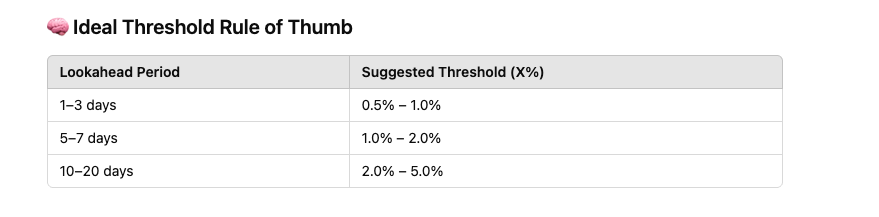

# **Thresholds with Quantiles **

In [34]:
import pandas as pd
import numpy as np

def determine_thresholds_via_quantiles(
    df,
    close_col="Close",
    lookahead=10,
    lower_quantile=0.25,
    upper_quantile=0.75
):
    """
    1) Computes the forward 30-day return.
    2) Determines threshold boundaries for 3-class labeling by
       picking the returns at 'lower_quantile' and 'upper_quantile'.
    3) Returns the two thresholds.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least a 'Close' price column.
    close_col : str
        Column name for the asset's close price. Default = 'Close'.
    lookahead : int
        Number of days ahead to compute forward return.
    lower_quantile : float
        Quantile for the DOWN/FLAT boundary.
    upper_quantile : float
        Quantile for the FLAT/UP boundary.

    Returns
    -------
    (float, float)
        A tuple (lower_threshold, upper_threshold).
    """

    data = df.copy()

    # Compute the forward return = (Close[t+lookahead] / Close[t]) - 1
    data["Forward_Return"] = data[close_col].shift(-lookahead) / data[close_col] - 1

    # Drop rows where Forward_Return is NaN (due to shift)
    data.dropna(subset=["Forward_Return"], inplace=True)

    # Get the distribution of forward returns
    lower_threshold = data["Forward_Return"].quantile(lower_quantile)
    upper_threshold = data["Forward_Return"].quantile(upper_quantile)

    return lower_threshold, upper_threshold

def label_3class(x, lower_threshold, upper_threshold):
    """
    Given a forward return x, return:
      -1 if x < lower_threshold  (DOWN)
       0 if lower_threshold <= x <= upper_threshold (FLAT)
       1 if x > upper_threshold  (UP)
    """
    if x < lower_threshold:
        return -1
    elif x > upper_threshold:
        return 1
    else:
        return 0

# Example usage:
if __name__ == "__main__":
    # Suppose df has a Date index and a 'Close' column.
    # For illustration, let's create a simple random 'Close' series:
    df_example = df_stock.copy()

    # 1) Determine thresholds for 30-day lookahead using 25th and 75th percentiles
    lower_thr, upper_thr = determine_thresholds_via_quantiles(
        df_example, close_col="Close", lookahead=20, lower_quantile=0.25, upper_quantile=0.75
    )
    print(f"Calculated thresholds:\n  Lower: {lower_thr:.3%}\n  Upper: {upper_thr:.3%}")

    # 2) Label the entire DataFrame using these thresholds
    df_example["Forward_Return"] = df_example["Close"].shift(-30) / df_example["Close"] - 1
    df_example["Label"] = df_example["Forward_Return"].apply(
        lambda x: label_3class(x, lower_thr, upper_thr)
    )

    # Check final distribution of classes (excluding NaN from shift)
    final_df = df_example.dropna(subset=["Forward_Return", "Label"])
    print("\nClass distribution:")
    print(final_df["Label"].value_counts())


Calculated thresholds:
  Lower: -6.563%
  Upper: 12.241%

Class distribution:
Label
 0    2642
 1    2011
-1    1732
Name: count, dtype: int64


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

def tune_technical_rf_asymmetric(
    df,
    tech_features,
    close_col="Close",
    down_thresholds=[0.05],
    up_thresholds=[0.08],
    lookaheads=[5, 7, 10 ,30],
    test_sizes=[0.2],
    rf_param_grid=None,
    random_state=42
):
    if rf_param_grid is None:
        rf_param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [5, 7],
            'min_samples_leaf': [3, 5]
        }

    param_grid = list(ParameterGrid(rf_param_grid))
    results = []

    def label_return_asymmetric(x, d_thr, u_thr):
        if x < -d_thr:
            return -1
        elif x > u_thr:
            return 1
        else:
            return 0

    for down_threshold in down_thresholds:
        for up_threshold in up_thresholds:
            for lookahead in lookaheads:
                for test_size in test_sizes:
                    for params in param_grid:
                        data = df.copy()
                        data["Forward_Return"] = data[close_col].shift(-lookahead) / data[close_col] - 1
                        data["Target_3Class"] = data["Forward_Return"].apply(
                            lambda x: label_return_asymmetric(x, down_threshold, up_threshold)
                        )

                        data_model = data.dropna(subset=tech_features + ["Target_3Class"])
                        # Inside the inner loop, after Target_3Class creation
                        label_counts = data["Target_3Class"].value_counts().to_dict()
                        # print(label_counts)

                        if data_model.empty or data_model["Target_3Class"].nunique() < 2:
                            continue

                        X = data_model[tech_features]
                        y = data_model["Target_3Class"]

                        # try:
                        #     X_resampled, y_resampled = SMOTE(random_state=random_state).fit_resample(X, y)
                        # except ValueError:
                        #     continue

                        X_train, X_test, y_train, y_test = train_test_split(
                            X, y, test_size=test_size, random_state=random_state, stratify= y
                        )

                        rf = RandomForestClassifier(random_state=random_state, class_weight= 'balanced_subsample' , **params)
                        rf.fit(X_train, y_train)

                        y_train_pred = rf.predict(X_train)
                        y_test_pred = rf.predict(X_test)

                        # Get feature importances and score
                        fund_weights = rf.feature_importances_ / np.sum(rf.feature_importances_)
                        fund_score_raw = np.dot(X, fund_weights)
                        fund_score_norm = MinMaxScaler((0, 100)).fit_transform(fund_score_raw.reshape(-1, 1)).flatten()
                        data_model["Fund_Score_RF_Tuned"] = fund_score_norm
                        data.loc[data_model.index, "Fund_Score_RF_Tuned"] = data_model["Fund_Score_RF_Tuned"]



                        # Class-wise metrics
                        labels = [-1, 0, 1]
                        test_f1_pc = f1_score(y_test, y_test_pred, average=None, labels=labels, zero_division=0)
                        test_prec_pc = precision_score(y_test, y_test_pred, average=None, labels=labels, zero_division=0)
                        test_recall_pc = recall_score(y_test, y_test_pred, average=None, labels=labels, zero_division=0)

                        fund_weights = rf.feature_importances_ / np.sum(rf.feature_importances_)
                        results.append({
                            "Down_Threshold": down_threshold,
                            "Up_Threshold": up_threshold,
                            "Lookahead": lookahead,
                            "Test_Size": test_size,
                            "Test_Accuracy": accuracy_score(y_test, y_test_pred),
                            "Train_F1_Macro"  :f1_score(y_train, y_train_pred, average='macro', zero_division=0),
                            "Test_F1_Macro": f1_score(y_test, y_test_pred, average='macro', zero_division=0),
                            "F1_gap": f1_score(y_train, y_train_pred, average='macro', zero_division=0) - f1_score(y_test, y_test_pred, average='macro', zero_division=0),
                            "Test_Precision_Macro": precision_score(y_test, y_test_pred, average='macro', zero_division=0),
                            "Test_Recall_Macro": recall_score(y_test, y_test_pred, average='macro', zero_division=0),

                            "Test_F1_-1": test_f1_pc[0],
                            "Test_F1_0": test_f1_pc[1],
                            "Test_F1_1": test_f1_pc[2],
                            "Test_Precision_-1": test_prec_pc[0],
                            "Test_Precision_0": test_prec_pc[1],
                            "Test_Precision_1": test_prec_pc[2],
                            "Test_Recall_-1": test_recall_pc[0],
                            "Test_Recall_0": test_recall_pc[1],
                            "Test_Recall_1": test_recall_pc[2],

                            "Label_Count_-1": label_counts.get(-1, 0),
                            "Label_Count_0": label_counts.get(0, 0),
                            "Label_Count_1": label_counts.get(1, 0),


                            **params,
                            "Feature_Weights": dict(zip(tech_features, fund_weights)),
                            "Fund_Score_Col": data["Fund_Score_RF_Tuned"] if "Fund_Score_RF_Tuned" in data else None
                        })

    return pd.DataFrame(results)


In [36]:

df_stock.reset_index(drop=True, inplace=True)

In [37]:
tech_results_df = tune_technical_rf_asymmetric(
    df=df_stock,
    tech_features=[ "RSI_Score", "MACD_Score", "SMA_Score", "ATR_Score" ,"Trading_View_Technical_Score"
    ],
    close_col="Close",
    down_thresholds=[0.05 ,0.08 , 0.10, 0.15 ,0.20 ],
    up_thresholds=[0.05,0.08,0.10 ,0.15 ,0.20 ],
    lookaheads=[10,20, 30],
    rf_param_grid={
        'n_estimators': [100, 200,300],
        'max_depth': [3,5, 7],
        'min_samples_leaf': [3, 5]
    }
)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model["Fund_Score_RF_Tuned"] = fund_score_norm
<ipython-input-35-65977dd00e9b>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model["Fund_Score_RF_Tuned"] = fund_score_norm
<ipython-input-35-65977dd00e9b>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model["Fund_Score_RF_Tuned"] = fund_score_norm


In [38]:
def tag_fit_quality(row, min_f1=0.55, max_gap=0.10):
    if row["Test_F1_Macro"] < min_f1 and row["Train_F1_Macro"] < min_f1:
        return "Underfitting"
    elif row["F1_gap"] > max_gap:
        return "Overfitting"
    elif row["Test_F1_Macro"] >= min_f1 and row["F1_gap"] <= max_gap:
        return "Good Fit"
    else:
        return "Uncertain"

tech_results_df["Fit_Quality"] = tech_results_df.apply(tag_fit_quality, axis=1)

In [39]:
tech_results_df


,Down_Threshold,Up_Threshold,Lookahead,Test_Size,Test_Accuracy,Train_F1_Macro,Test_F1_Macro,F1_gap,Test_Precision_Macro,Test_Recall_Macro,...,Test_Recall_1,Label_Count_-1,Label_Count_0,Label_Count_1,max_depth,min_samples_leaf,n_estimators,Feature_Weights,Fund_Score_Col,Fit_Quality
0,0.05,0.05,10,0.2,0.434335,0.456048,0.431204,0.024844,0.441343,0.441005,...,0.385514,1543,2682,2190,3,3,100,"{'RSI_Score': 0.09858754206787144, 'MACD_Score...",0 NaN 1 NaN 2 ...,Underfitting
1,0.05,0.05,10,0.2,0.434335,0.459320,0.432060,0.027260,0.442321,0.442706,...,0.397196,1543,2682,2190,3,3,200,"{'RSI_Score': 0.10584027908102907, 'MACD_Score...",0 NaN 1 NaN 2 ...,Underfitting
2,0.05,0.05,10,0.2,0.435127,0.459138,0.432762,0.026376,0.443056,0.443015,...,0.399533,1543,2682,2190,3,3,300,"{'RSI_Score': 0.1057022007236413, 'MACD_Score'...",0 NaN 1 NaN 2 ...,Underfitting
3,0.05,0.05,10,0.2,0.435127,0.455552,0.432339,0.023213,0.442268,0.441605,...,0.399533,1543,2682,2190,3,5,100,"{'RSI_Score': 0.09773406523998096, 'MACD_Score...",0 NaN 1 NaN 2 ...,Underfitting
4,0.05,0.05,10,0.2,0.433544,0.459095,0.431223,0.027872,0.441537,0.441292,...,0.399533,1543,2682,2190,3,5,200,"{'RSI_Score': 0.1056073648263715, 'MACD_Score'...",0 NaN 1 NaN 2 ...,Underfitting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,0.20,0.20,30,0.2,0.605222,0.612297,0.544932,0.067364,0.539323,0.643799,...,0.689815,736,4544,1135,7,3,200,"{'RSI_Score': 0.08310164052950966, 'MACD_Score...",0 NaN 1 NaN 2 ...,Uncertain
1346,0.20,0.20,30,0.2,0.608386,0.609841,0.546429,0.063412,0.539421,0.644106,...,0.685185,736,4544,1135,7,3,300,"{'RSI_Score': 0.08112857742452091, 'MACD_Score...",0 NaN 1 NaN 2 ...,Uncertain
1347,0.20,0.20,30,0.2,0.618671,0.613417,0.552118,0.061299,0.543582,0.647018,...,0.685185,736,4544,1135,7,5,100,"{'RSI_Score': 0.08358609235826014, 'MACD_Score...",0 NaN 1 NaN 2 ...,Good Fit
1348,0.20,0.20,30,0.2,0.606013,0.605639,0.543403,0.062235,0.538386,0.643720,...,0.680556,736,4544,1135,7,5,200,"{'RSI_Score': 0.08318444780865532, 'MACD_Score...",0 NaN 1 NaN 2 ...,Uncertain


In [40]:
perfect_fits = tech_results_df[
    (tech_results_df["Test_F1_Macro"] >= 0.50) &
    (tech_results_df["F1_gap"] <= 0.05) &
    (tech_results_df["Test_Accuracy"] >= 0.55) &
     (tech_results_df["Fit_Quality"] == "Good Fit")&
    (tech_results_df["Label_Count_-1"] >= 500)&
    (tech_results_df["Label_Count_0"] >= 500)&
    (tech_results_df["Label_Count_1"] >= 500)
].sort_values(by="Test_F1_Macro", ascending=False)

In [41]:
perfect_fits

,Down_Threshold,Up_Threshold,Lookahead,Test_Size,Test_Accuracy,Train_F1_Macro,Test_F1_Macro,F1_gap,Test_Precision_Macro,Test_Recall_Macro,...,Test_Recall_1,Label_Count_-1,Label_Count_0,Label_Count_1,max_depth,min_samples_leaf,n_estimators,Feature_Weights,Fund_Score_Col,Fit_Quality
106,0.05,0.08,30,0.2,0.612342,0.650887,0.601781,0.049106,0.612534,0.602116,...,0.706349,1912,1913,2590,7,5,200,"{'RSI_Score': 0.11220127761591295, 'MACD_Score...",0 NaN 1 NaN 2 ...,Good Fit
321,0.08,0.05,30,0.2,0.617880,0.649684,0.601555,0.048130,0.603611,0.607977,...,0.678694,1568,1863,2984,7,5,100,"{'RSI_Score': 0.08793084430060348, 'MACD_Score...",0 NaN 1 NaN 2 ...,Good Fit
323,0.08,0.05,30,0.2,0.616297,0.647051,0.599321,0.047730,0.601743,0.606182,...,0.680412,1568,1863,2984,7,5,300,"{'RSI_Score': 0.08986852964137756, 'MACD_Score...",0 NaN 1 NaN 2 ...,Good Fit
103,0.05,0.08,30,0.2,0.608386,0.645769,0.598576,0.047193,0.608341,0.599241,...,0.692460,1912,1913,2590,7,3,200,"{'RSI_Score': 0.1141342250029097, 'MACD_Score'...",0 NaN 1 NaN 2 ...,Good Fit
102,0.05,0.08,30,0.2,0.607595,0.648197,0.598406,0.049791,0.607407,0.599011,...,0.686508,1912,1913,2590,7,3,100,"{'RSI_Score': 0.11103143060043034, 'MACD_Score...",0 NaN 1 NaN 2 ...,Good Fit
104,0.05,0.08,30,0.2,0.608386,0.647229,0.597625,0.049604,0.611035,0.598594,...,0.698413,1912,1913,2590,7,3,300,"{'RSI_Score': 0.1117890151447693, 'MACD_Score'...",0 NaN 1 NaN 2 ...,Good Fit
322,0.08,0.05,30,0.2,0.613924,0.646776,0.597475,0.049301,0.598972,0.604296,...,0.675258,1568,1863,2984,7,5,200,"{'RSI_Score': 0.08772475855822495, 'MACD_Score...",0 NaN 1 NaN 2 ...,Good Fit
376,0.08,0.08,30,0.2,0.592563,0.626261,0.584242,0.042019,0.598117,0.593712,...,0.690476,1568,2257,2590,7,5,200,"{'RSI_Score': 0.09928166555457468, 'MACD_Score...",0 NaN 1 NaN 2 ...,Good Fit
377,0.08,0.08,30,0.2,0.592563,0.623886,0.583257,0.040629,0.598244,0.592732,...,0.698413,1568,2257,2590,7,5,300,"{'RSI_Score': 0.09726869640656723, 'MACD_Score...",0 NaN 1 NaN 2 ...,Good Fit
373,0.08,0.08,30,0.2,0.590190,0.622532,0.581320,0.041212,0.597433,0.592694,...,0.692460,1568,2257,2590,7,3,200,"{'RSI_Score': 0.09738618608474768, 'MACD_Score...",0 NaN 1 NaN 2 ...,Good Fit


In [42]:
tech_weights = perfect_fits['Feature_Weights'].iloc[0]


In [43]:
tech_weights

{'RSI_Score': np.float64(0.11220127761591295),
 'MACD_Score': np.float64(0.12484119840337814),
 'SMA_Score': np.float64(0.27350187320249103),
 'ATR_Score': np.float64(0.35591521302244344),
 'Trading_View_Technical_Score': np.float64(0.13354043775577445)}

In [44]:
features =     [ "RSI_Score", "MACD_Score", "SMA_Score", "ATR_Score"
    ]

X = df_stock[features]
tech_weights_list = [tech_weights[feature] for feature in features]
df_stock['Tech_Score_comp'] = np.dot(X,tech_weights_list)

In [45]:
df_stock.tail(25)

,Date,Open,High,Low,Close,SMA_50,SMA_200,RSI,MACD_Line,MACD_Signal,...,RSI_Score,MACD_Score,SMA_Score,ATR_Score,Trading_View_Technical_Score,Target_Up,Final_Tech_Score_LogReg,Final_Tech_Score_Corr,Final_Tech_Score_RF,Tech_Score_comp
6390,2025-03-28,111.485,112.8700,109.0701,109.67,124.9320,132.2804,39.226188,-3.117698,-3.091761,...,39.226188,49.740635,42.6516,4.666010,34.071108,0,17.022898,63.900368,72.572749,23.936905
6391,2025-03-31,105.130,110.9550,103.6500,108.38,124.4282,132.0102,38.101733,-3.474829,-3.168375,...,38.101733,46.935456,42.4180,4.766622,33.055453,1,16.584903,63.449377,72.317506,23.432457
6392,2025-04-01,108.515,110.2000,106.4700,110.15,123.8770,131.7512,40.617069,-3.573837,-3.249467,...,40.617069,46.756299,42.1258,4.647701,33.536717,0,17.852160,64.048219,72.426956,23.570072
6393,2025-04-02,107.290,111.9800,106.7900,110.42,123.2688,131.4563,41.010859,-3.589142,-3.317402,...,41.010859,47.282603,41.8125,4.623996,33.682489,1,18.040749,64.158773,72.458548,23.585835
6394,2025-04-03,103.510,105.6300,101.6000,101.80,122.3634,131.0182,33.396515,-4.247866,-3.503495,...,33.396515,42.556289,41.3452,4.817596,30.528900,1,14.268527,61.923447,71.679902,22.082555
6395,2025-04-04,98.910,100.1300,92.1100,94.31,121.3052,130.4725,28.453145,-5.313045,-3.865405,...,28.453145,35.523603,40.8327,5.049043,27.464623,1,12.017152,60.244791,70.915916,20.592140
6396,2025-04-07,87.460,101.7500,86.6200,97.64,120.4056,129.9726,33.188172,-5.821398,-4.256604,...,33.188172,34.352058,40.4330,5.587081,28.390078,1,15.006592,61.477917,71.137008,21.059336
6397,2025-04-08,103.805,105.8500,94.4600,96.30,119.9632,129.4830,32.262876,-6.260234,-4.657330,...,32.262876,33.970957,40.4802,5.864541,28.144644,1,14.734624,61.272666,71.081255,21.019601
6398,2025-04-09,98.890,115.1000,97.5301,114.33,119.6700,129.1434,51.753903,-5.094419,-4.744748,...,51.753903,46.503283,40.5266,6.562318,36.336526,0,25.337039,67.185208,73.103430,25.032109
6399,2025-04-10,109.370,110.8600,99.1500,107.57,119.3474,128.7564,46.366850,-4.662235,-4.728245,...,46.366850,50.660102,40.5910,6.995235,36.153297,0,22.676009,66.129705,73.078282,25.118313


**#Exporting the Technical File**

In [46]:
# prompt: how to reset index here

df_stock.reset_index(drop=True, inplace=True)


In [47]:
df_stock["Date"] = pd.to_datetime(df_stock["Date"])

In [48]:
five_years_ago = datetime.now() - timedelta(days=5*365)
df_stock = df_stock[df_stock["Date"] >= five_years_ago]

In [49]:
df_stock.head()

,Date,Open,High,Low,Close,SMA_50,SMA_200,RSI,MACD_Line,MACD_Signal,...,RSI_Score,MACD_Score,SMA_Score,ATR_Score,Trading_View_Technical_Score,Target_Up,Final_Tech_Score_LogReg,Final_Tech_Score_Corr,Final_Tech_Score_RF,Tech_Score_comp
5161,2020-05-07,303.38,307.41,301.32,304.87,263.3646,257.3724,60.622131,9.909554,9.685277,...,60.622131,52.242769,55.9922,10.920749,44.944462,1,32.729797,71.534971,75.491059,32.524763
5162,2020-05-08,307.75,312.75,306.39,312.50,264.5626,258.2575,63.157590,10.825650,9.913352,...,63.157590,59.122980,56.3051,10.608747,47.298605,1,33.644112,72.556337,76.079214,33.642711
5163,2020-05-11,312.30,324.50,311.15,322.62,265.6136,259.2322,66.260596,12.227313,10.376144,...,66.260596,68.511688,56.3814,10.643936,50.449405,1,35.068040,73.926961,76.867958,35.196362
5164,2020-05-12,324.94,326.90,311.71,312.10,266.3270,260.0703,60.551356,12.346937,10.770303,...,60.551356,65.766343,56.2567,10.785902,48.340075,1,32.207344,72.310649,76.351386,34.229468
5165,2020-05-13,316.70,323.14,303.79,311.20,267.2332,260.8872,60.074459,12.228159,11.061874,...,60.074459,61.662850,56.3460,11.164822,47.312033,1,32.353791,72.021510,76.098124,33.822962


In [50]:
final_technical_score = df_stock[['Date','RSI_Score' , 'MACD_Score' ,'SMA_Score' ,'ATR_Score', 'Tech_Score_comp']]

In [51]:
final_technical_score = final_technical_score.rename(columns={'Date': 'date',
                                                              'RSI_Score': 'rsi_score',
                                                              'MACD_Score': 'macd_score',
                                                              'SMA_Score': 'sma_score',
                                                              'ATR_Score': 'atr_score',
                                                              'Tech_Score_comp': 'technical_score'})


In [52]:
final_technical_score['ticker'] = selected_ticker

In [53]:
final_technical_score = final_technical_score.round(2)

In [54]:
final_technical_score.head()

,date,rsi_score,macd_score,sma_score,atr_score,technical_score,ticker
5161,2020-05-07,60.62,52.24,55.99,10.92,32.52,NVDA
5162,2020-05-08,63.16,59.12,56.31,10.61,33.64,NVDA
5163,2020-05-11,66.26,68.51,56.38,10.64,35.20,NVDA
5164,2020-05-12,60.55,65.77,56.26,10.79,34.23,NVDA
5165,2020-05-13,60.07,61.66,56.35,11.16,33.82,NVDA


In [55]:
export_path = f"/content/drive/My Drive/StockDashboard_Automation/ExportToGitHub/technical_scores.csv"
final_technical_score.to_csv(export_path, index=False)

print(f"✅ Exported Technical Scores to {export_path}")

✅ Exported Technical Scores to /content/drive/My Drive/StockDashboard_Automation/ExportToGitHub/technical_scores.csv
